In [ ]:
import np

from data.processing import ParseBalanced
"Transformer-Classification-ALIBI""Transformer-Classification-ALIBI"
directory = "large-melspec-dataset-top-50-LIBROSA"
data_directory = "E:/mtg-jamendo/"
subset_file_name = "autotagging_top50tags"
ParseBalanced(subset_file_name, f"{data_directory}", f"E:/SongsDataset/{directory}", convert=True, target_per_genre=1300)

In [1]:
from torchaudio.transforms import FrequencyMasking, TimeMasking
from torch import nn
from data.data_utils import *
from models.AudioResnet import AudioResnet
from utils import misc

augmentations = Compose([
    AddGaussianNoise(std=0.25),
    TimeMasking(time_mask_param=int(0.05* 256)),
    FrequencyMasking(freq_mask_param=int(0.05 * 128)),
])

large_directory = "large-melspec-dataset-top-50-LIBROSA"

class Config:
    # === General ===

    model_name = "Transformer-Classification-ALIBI"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32
    save_path = f"trained_models\\{model_name}\\"
    seed = 42

    # === Training ===
    num_classes = 50
    num_epochs = 100
    batch_size = 1
    max_batch_size = 32
    learning_rate = 1e-4
    min_learning_rate = 1e-4
    weight_decay = 1e-4

    warmup_threshold = 1.0 / 100.0
    step_coefficient = 25.0 / 100.0

    gamma = 1.0
    save_checkpoints = True

    # === Dataset ===
    transforms = None
    use_masks = True
    num_workers = 1
    prefetch_factor = 1
    val_split = 0.1
    shuffle = True
    pos_weight = torch.tensor([x * 50 for x in torch.load(f"E:\\SongsDataset\\{large_directory}\\pow_weights_ks.pt", weights_only=False)]).to("cuda")
    criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)#FocalLoss(gamma=0.5, reduction='mean', pos_weight=pos_weight)

In [2]:
from torch.utils.data import DataLoader

train_dataset = StreamingSongDataset(f"C:\\Dataset\\{large_directory}\\train_set\\data", f"E:\\SongsDataset\\{large_directory}\\train_set\\genre_labels", transform=augmentations)
test_dataset = StreamingSongDataset(f"E:\\SongsDataset\\{large_directory}\\test_set\\data", f"E:\\SongsDataset\\{large_directory}\\test_set\\genre_labels")

train_dataloader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers,
    prefetch_factor=Config.prefetch_factor,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers,
    prefetch_factor=Config.prefetch_factor,
)

In [4]:
from datasets import tqdm

all_labels = [0] * 50
total_length = 1
for batch in tqdm(train_dataloader):
        inputs, labels = batch
        labels = labels.squeeze(0).permute(0, 1)
        labels = torch.sum(labels, dim=0)
        labels = labels.to("cpu")

        for i, label in enumerate(labels):
            all_labels[i] += label

        total_length += inputs.shape[1]

for i in range(len(all_labels)):
    all_labels[i] = all_labels[i] / total_length

pow_weights_ks = []
for i in all_labels:
    k = 1.0 / i
    pow_weights_ks.append((50.0 - k) / k)

torch.save(pow_weights_ks, f"E:\\SongsDataset\\{large_directory}\\pow_weights_ks.pt")

  0%|          | 0/98 [00:00<?, ?it/s]


KeyboardInterrupt


KeyboardInterrupt



In [ ]:
from models.ShortChunkCNN import ShortChunkCNN

model = AudioResnet(num_classes=50)
print(f"{misc.model_size(model)} Parameters")

In [3]:
from vit_pytorch import ViT
from vit_pytorch.nest import NesT
from utils import misc

model = ViT(
    image_size = 256,
    patch_size = 8,
    dim = 256,
    heads = 4,
    num_classes = 50,
    channels = 1
)

print(f"{misc.model_size(model)} Parameters")

338071026 Parameters


In [3]:
from models.NESTCNN import NESTCNN
from utils import misc

model = NESTCNN(
    image_size = 256,
    patch_size = 8,
    dim = 256,
    cnn_initial_channels_dim = 32,
    heads = 4,
    num_hierarchies = 3,        # number of hierarchies
    block_repeats = (2, 3, 4),  # the number of transformer blocks at each hierarchy, starting from the bottom
    num_classes = 50,
    channels = 1
)

print(f"{misc.model_size(model)} Parameters")

67933170 Parameters


In [3]:
from models.AudioTransformerEmbeddings import AudioTransformerEmbeddings

model = AudioTransformerEmbeddings(patching="AvgPoolFeature", input_dim=128, d_model=512, length=256, num_heads=8, encoder_layers=8, dropout=0.1, use_alibi=True, num_classes=50)
print(f"{misc.model_size(model)} Parameters")

19409458 Parameters


In [6]:
from models.AudioTransformerClassifier import AudioTransformerClassifier
# 8.0 - 1
# 4.0 - 2
# 0.5 - 5
# 0.1

model = AudioTransformerClassifier(input_dim=128, d_model=256, length=256, num_heads=8, encoder_layers=12, dropout=0.1, use_alibi=True, num_classes=50, use_rope=False, custom_slopes=0.1)
print(f"{misc.model_size(model)} Parameters")

9635634 Parameters


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

probs mean,std,min,max: 0.6379979 0.26946056 0.00058863906 0.9972107
frac > 0.5: 0.7131201171875


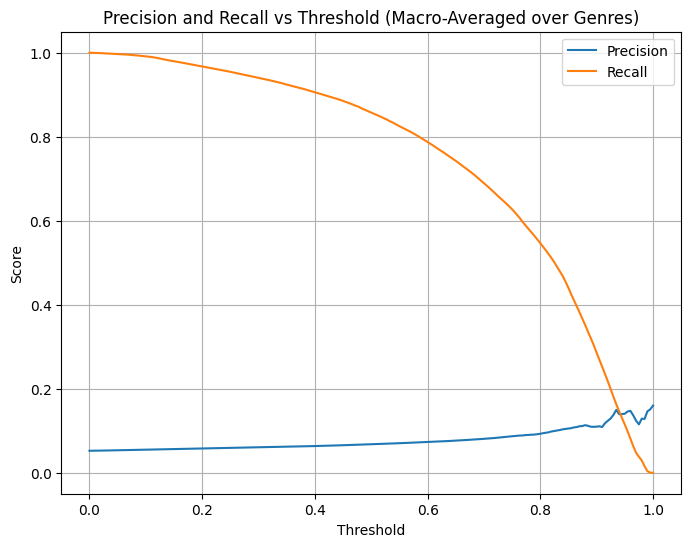

ROC-AUC: 0.6456	PR-AUC: 0.0987
Epoch 1, Train Loss: 2.2246
Epoch 1, Test Loss: 2.8966


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

probs mean,std,min,max: 0.6043443 0.30112356 7.036691e-05 0.9995939
frac > 0.5: 0.6578040660511364


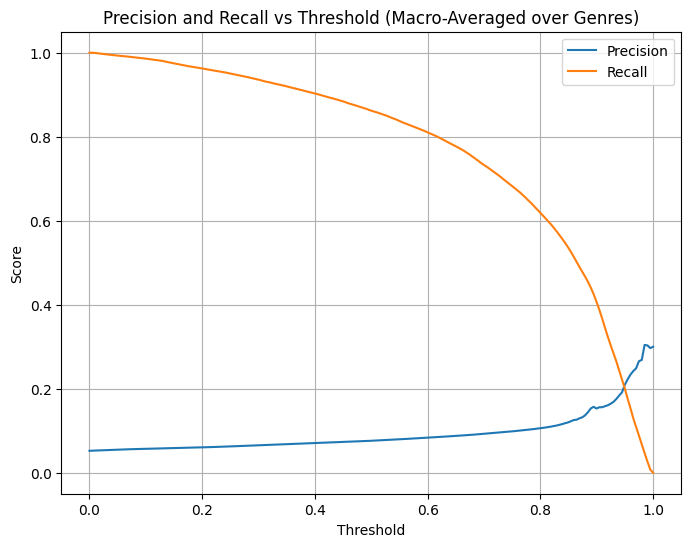

ROC-AUC: 0.6987	PR-AUC: 0.1338
Epoch 2, Train Loss: 1.9833
Epoch 2, Test Loss: 2.6468


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

probs mean,std,min,max: 0.54607826 0.30915275 5.711239e-05 0.999881
frac > 0.5: 0.5838472123579546


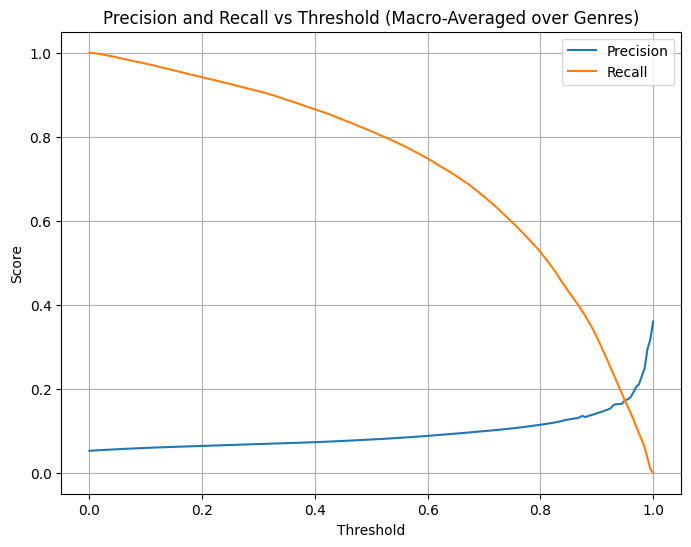

ROC-AUC: 0.6990	PR-AUC: 0.1344
Epoch 3, Train Loss: 1.9035
Epoch 3, Test Loss: 2.8323


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

probs mean,std,min,max: 0.5354997 0.32002917 8.185747e-07 0.99970967
frac > 0.5: 0.5838179154829546


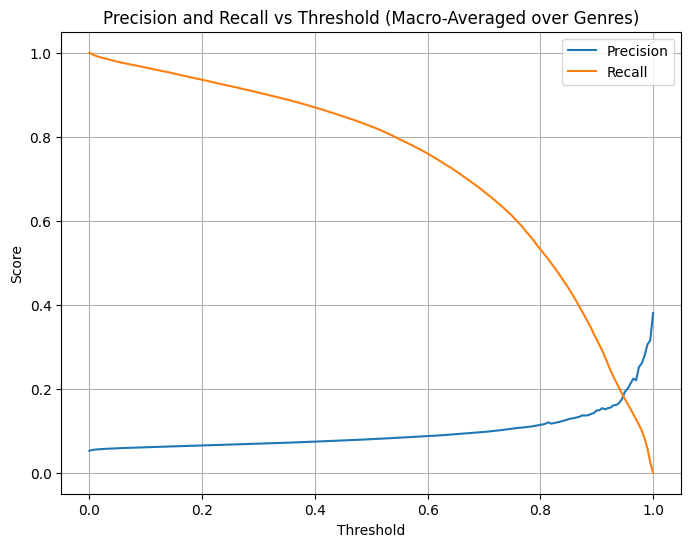

ROC-AUC: 0.7106	PR-AUC: 0.1446
Epoch 4, Train Loss: 1.8681
Epoch 4, Test Loss: 2.8537


  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
from training.classification_training import train_classifier
train_classifier(model, test_dataloader, train_dataloader, Config, show_graph=True)

In [1]:
import regex

loss_per_batch = []
reg = regex.compile("(?<=Batch [0-9]+ | Average: )[0-9]+.[0-9]+")
with open("E:/Coding/SongAnalyzer/Analyzer/src/trained_models/Transformer-Classification-ALIBI/loss.txt") as f:
    for line in f.readlines():
        captures = reg.findall(line)
        for capture in captures:
            loss_per_batch.append(float(capture))

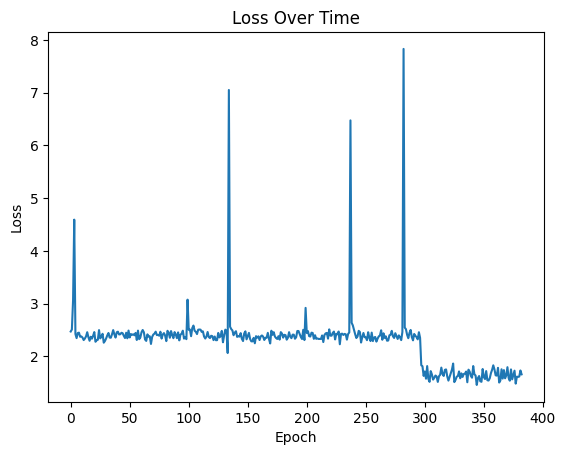

In [2]:
import matplotlib.pyplot as plt
x = [x for x in range(len(loss_per_batch))]
plt.plot(x, loss_per_batch)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")

plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

Eval Loss: 2.639708434316245


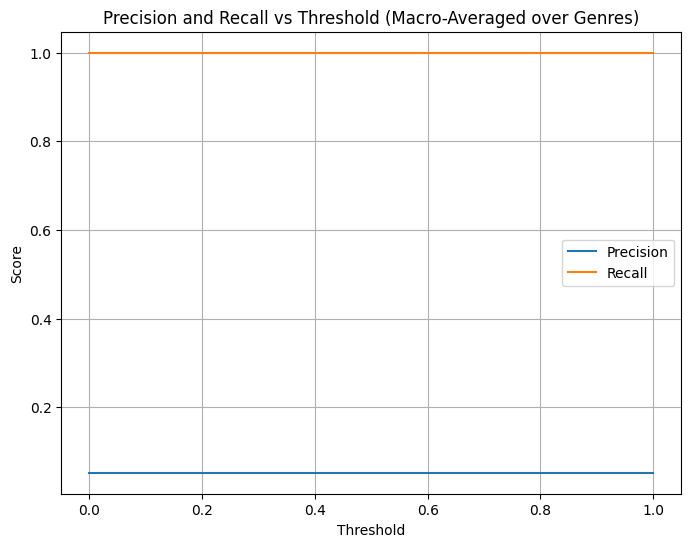

ROC-AUC: 0.5000	PR-AUC: 0.0524


  0%|          | 0/11 [00:00<?, ?it/s]

Eval Loss: 3.5285870180973276


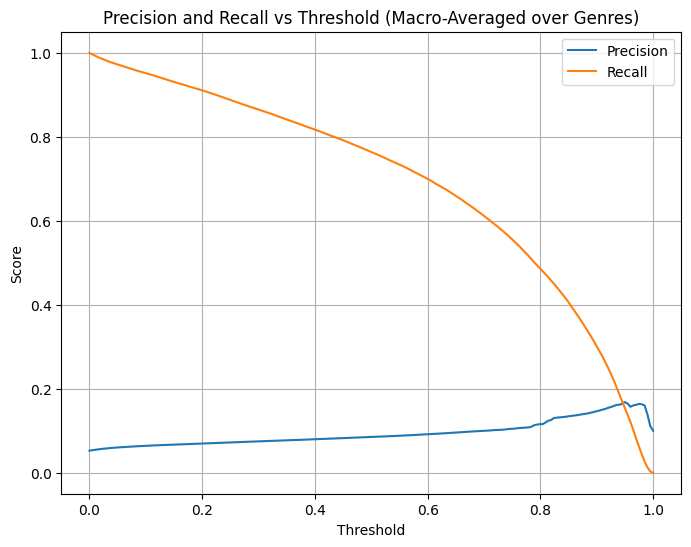

ROC-AUC: 0.6695	PR-AUC: 0.1167


  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from training.classification_training import evaluate_classification
from utils.visualization import visualize_ROC_PR_AUC

for num in range(1, 41):
    model = torch.load(f"E:/Coding/SongAnalyzer/Analyzer/src/trained_models/Transformer-Classification-ALIBI/Classifier-Epoch-{num}.pt", weights_only=False)

    test_loss_average, all_probs, all_labels = evaluate_classification(model, test_dataloader, Config)

    all_p_tensor = torch.stack([torch.tensor(x) for x in all_probs], dim=0).float()
    all_l_tensor = torch.stack([torch.tensor(x) for x in all_labels], dim=0).int()

    print(f"Eval Loss: {test_loss_average}")
    visualize_ROC_PR_AUC(all_p_tensor, all_l_tensor)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

probs mean,std,min,max: 0.036261637 0.13844278 0.00014571188 0.9999714
frac > 0.5: 0.02


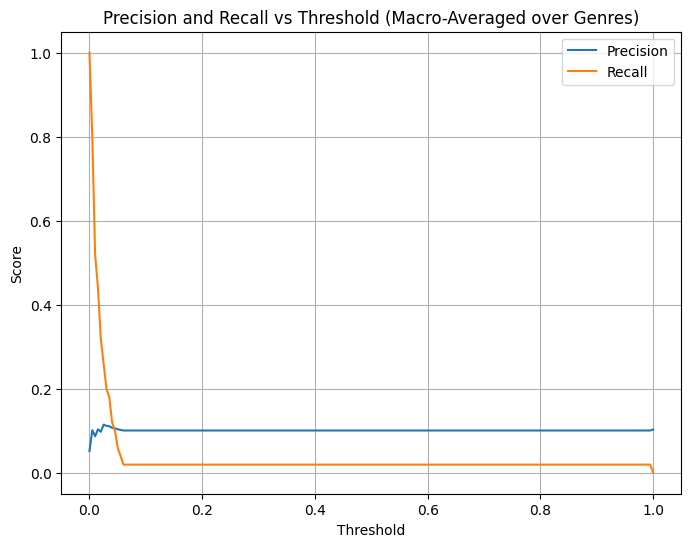

ROC-AUC: 0.4934	PR-AUC: 0.0529
Epoch 1, Train Loss: 0.2869
Epoch 1, Test Loss: 0.5862


  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
from models.AudioTransformerClassifier import AudioTransformerClassifier

model = AudioTransformerClassifier(input_dim=128, d_model=512, length=256, num_heads=8, encoder_layers=12, dropout=0.1, use_alibi=True, num_classes=50, use_rope=True)
print(f"{misc.model_size(model)} Parameters")
Config.model_name = "Transformer-Classification-ALIBI-ROPE"
from training.classification_training import train_classifier
train_classifier(model, test_dataloader, train_dataloader, Config, show_graph=True)

In [ ]:
def lav(file):
    model = torch.load(file, weights_only=False)

    test_loss_average, all_probs, all_labels = evaluate_classification(model, test_dataloader, Config)

    all_p_tensor = torch.stack([torch.tensor(x) for x in all_probs], dim=0).float()
    all_l_tensor = torch.stack([torch.tensor(x) for x in all_labels], dim=0).int()

    visualize_ROC_PR_AUC(all_p_tensor, all_l_tensor)
    print(f"Loss: {test_loss_average:04}")

for f in sorted(os.listdir("E:/Coding/SongAnalyzer/Analyzer/src/trained_models/NesT-TOP-50-LIBROSA-Augment-MEDIUM/"))[23:31]:
    file = "E:/Coding/SongAnalyzer/Analyzer/src/trained_models/NesT-TOP-50-LIBROSA-Augment-MEDIUM/" + f
    lav(file)

In [11]:
from data.processing import ReadStats

subset_file_name = "autotagging_top50tags"
tag_mapping = ReadStats(subset_file_name)
reversed_tag_mapping = {v: k for k, v in tag_mapping.items()}

In [9]:
from training.classification_training import evaluate_classification

test_loss_average, all_probs, all_labels = evaluate_classification(model, test_dataloader, Config)

all_p_tensor = torch.stack([torch.tensor(x) for x in all_probs], dim=0).float()
all_l_tensor = torch.stack([torch.tensor(x) for x in all_labels], dim=0).int()

print(f"Eval Loss: {test_loss_average}")

  0%|          | 0/11 [00:00<?, ?it/s]

Eval Loss: 0.22672560183458368


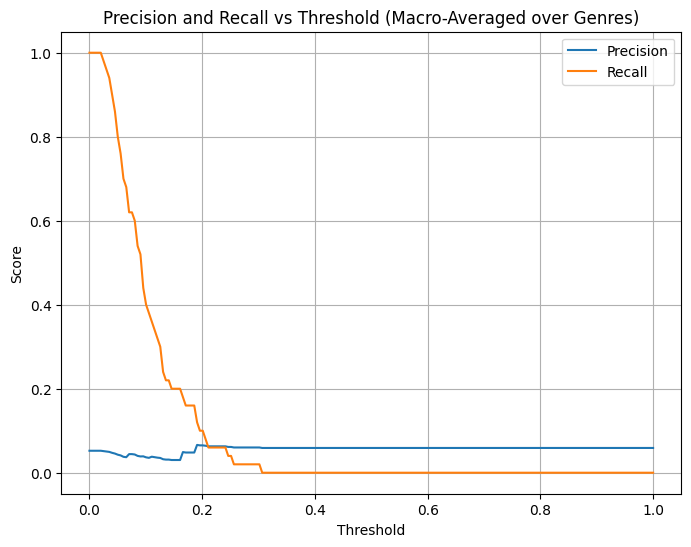

ROC-AUC: 0.4922	PR-AUC: 0.0522


(0.4922204643369808, 0.05219800431074699)

In [10]:
from utils.visualization import visualize_ROC_PR_AUC

visualize_ROC_PR_AUC(all_p_tensor, all_l_tensor)

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
def visualize_class_pr(all_l_tensor, all_p_tensor):
    for i in range(50):
        precision, recall, thresholds = precision_recall_curve(all_l_tensor[:, i], all_p_tensor[:, i])
        ap = average_precision_score(all_l_tensor[:, i], all_p_tensor[:, i])
        plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    #plt.legend()
    plt.title("Per-Class Precision-Recall Curves")
    plt.grid(True)
    plt.show()

    ap_per_class = [average_precision_score(all_l_tensor[:, i], all_p_tensor[:, i]) for i in range(50)]
    print(f"AP per class:\n")
    for index in range(len(ap_per_class)):
        print(f"{reversed_tag_mapping[index]:<20}: {ap_per_class[index]:.03f}")

In [ ]:
visualize_class_pr(all_l_tensor, all_p_tensor)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

def compute_full_multilabel_confusion_matrix(preds, targets, threshold=0.5):
    preds = np.array(preds)
    targets = np.array(targets)

    # Binarize predictions
    preds = (preds >= threshold).astype(int)

    return multilabel_confusion_matrix(targets, preds)

In [ ]:
conf_matrix = compute_full_multilabel_confusion_matrix(all_p_tensor, all_l_tensor)
for i, cm in enumerate(conf_matrix):
    print(f"Class {i}:\n[[TN: {cm[0,0]}  FP: {cm[0,1]}]\n [FN: {cm[1,0]}  TP: {cm[1,1]}]]\n")

In [13]:
from training.inference import inference_on_directory

directory = "E:/SongsDataset/songs"
df = inference_on_directory(subset_file_name, directory, Config, model, num_songs=30, aggregation='mean')

Reading: 54380 tracks, 11107 albums, 3517 artists


100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Confidence Scores for Piano- City Ruins


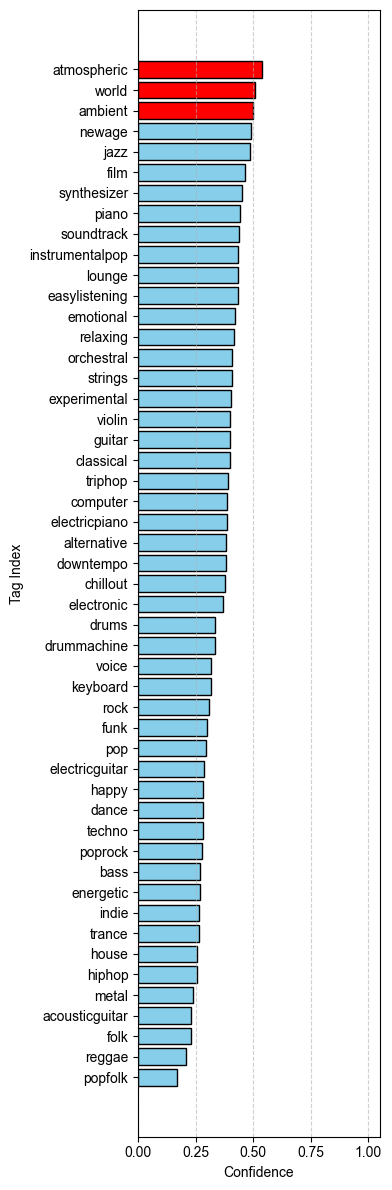

Confidence Scores for Get Lucky (feat. Pharrell Williams and Nile Rodgers)


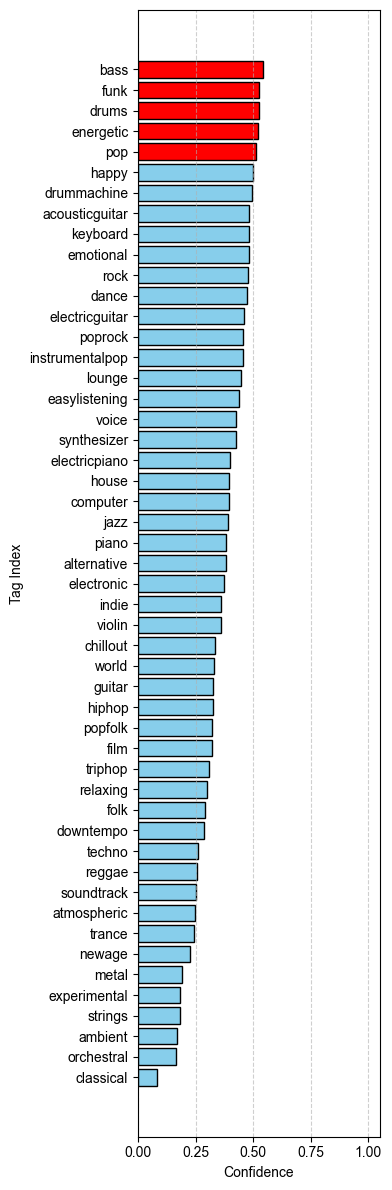

Confidence Scores for Change The Formality


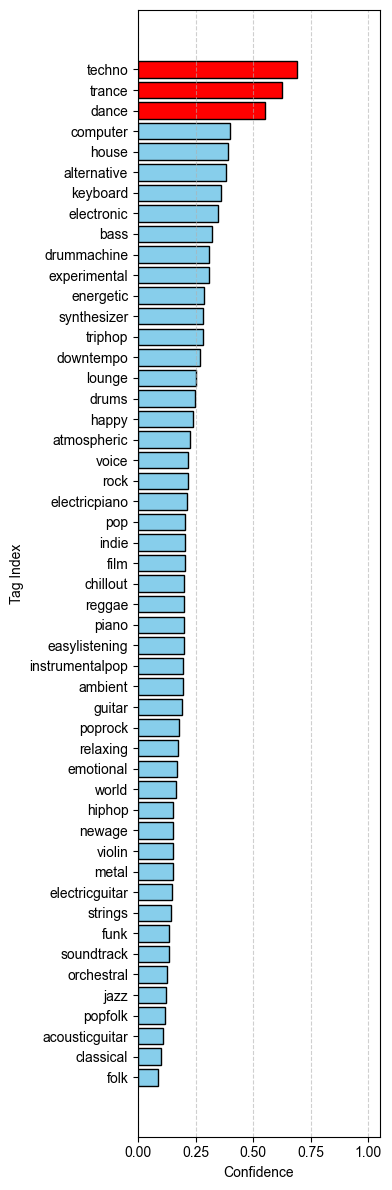

Confidence Scores for Gotta Go Fast (Sonic X Theme)


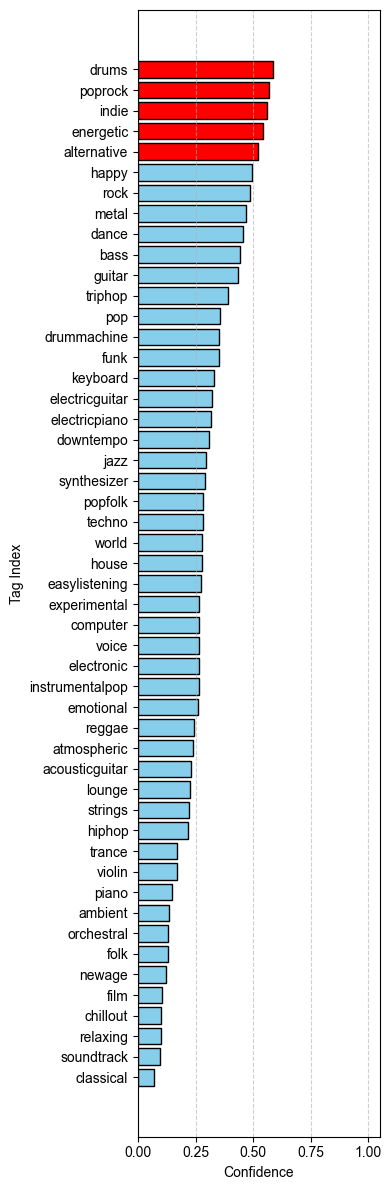

Confidence Scores for BLOOD X


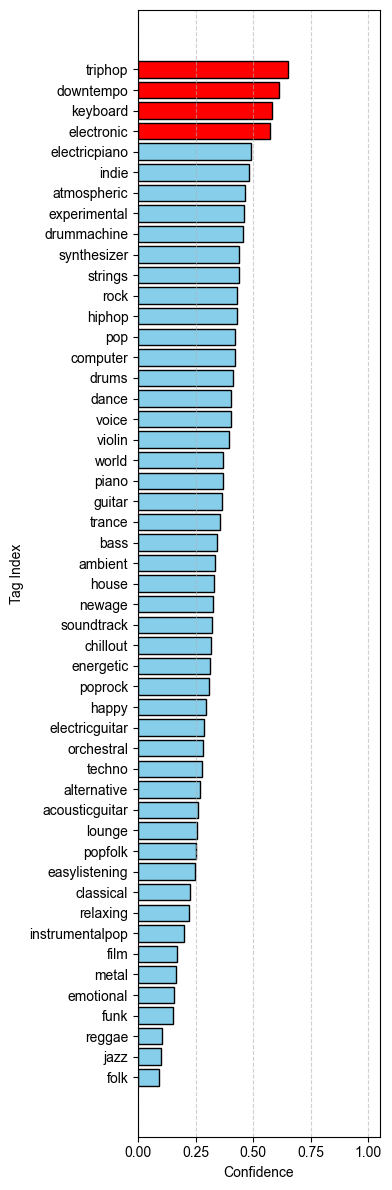

Confidence Scores for Ghibli


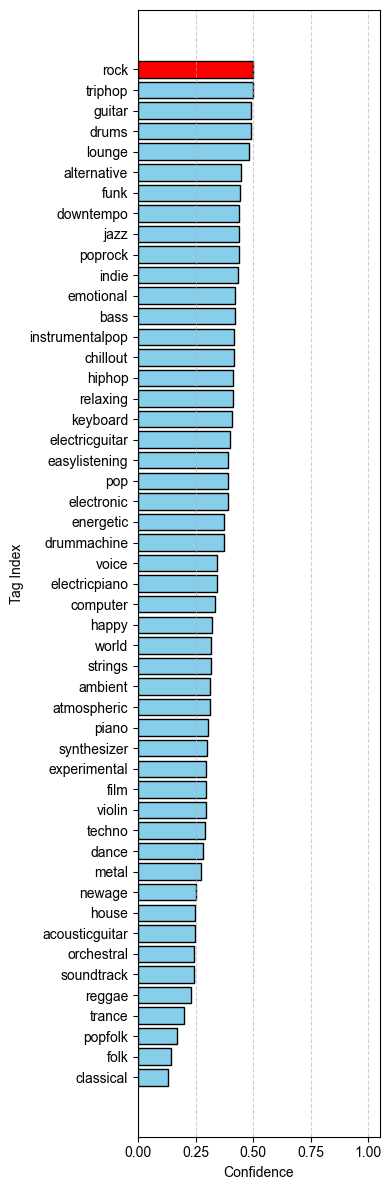

Confidence Scores for 眠れない


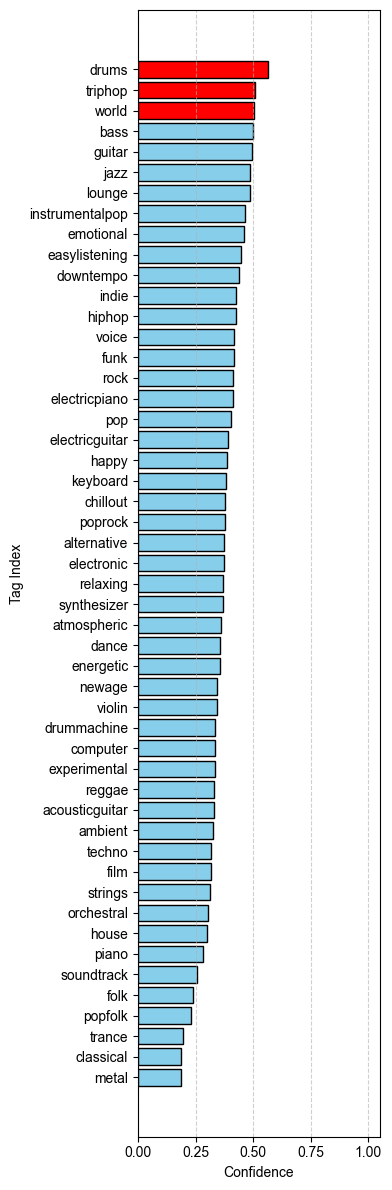

Confidence Scores for 我亲爱傀儡


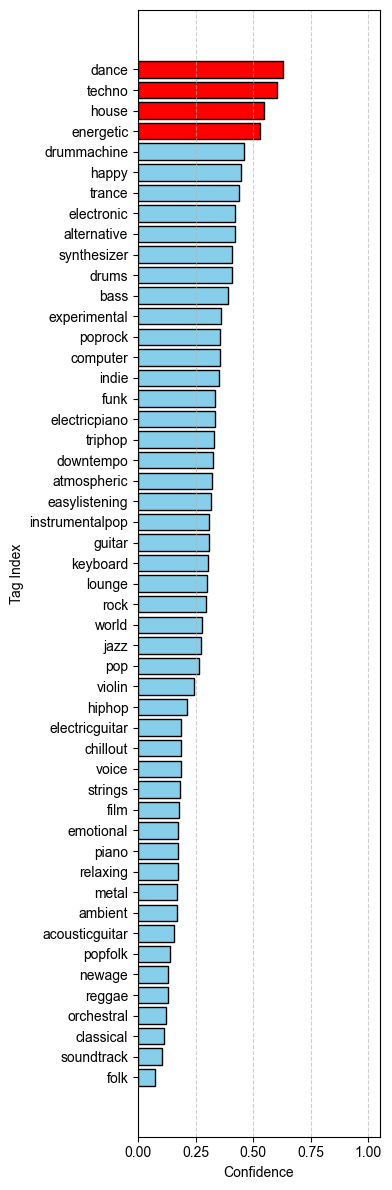

Confidence Scores for 1AM (From 'Animal Crossing- New Leaf')


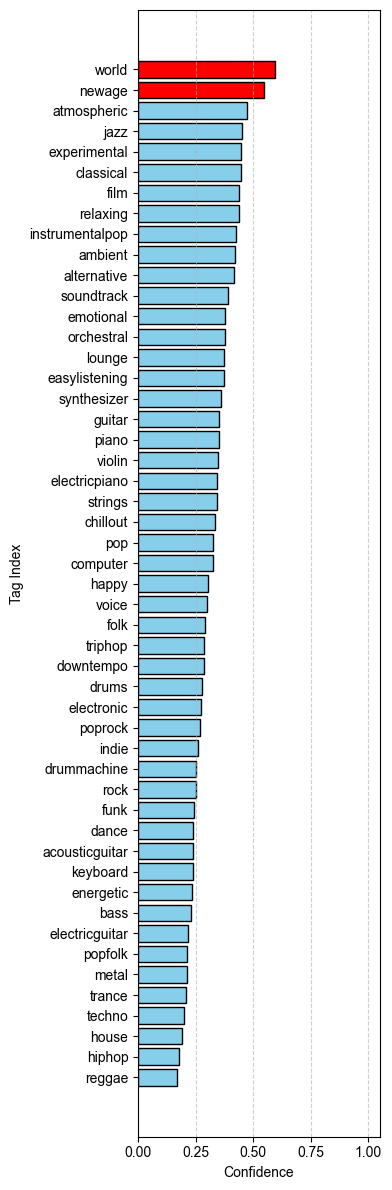

Confidence Scores for Look In The Window


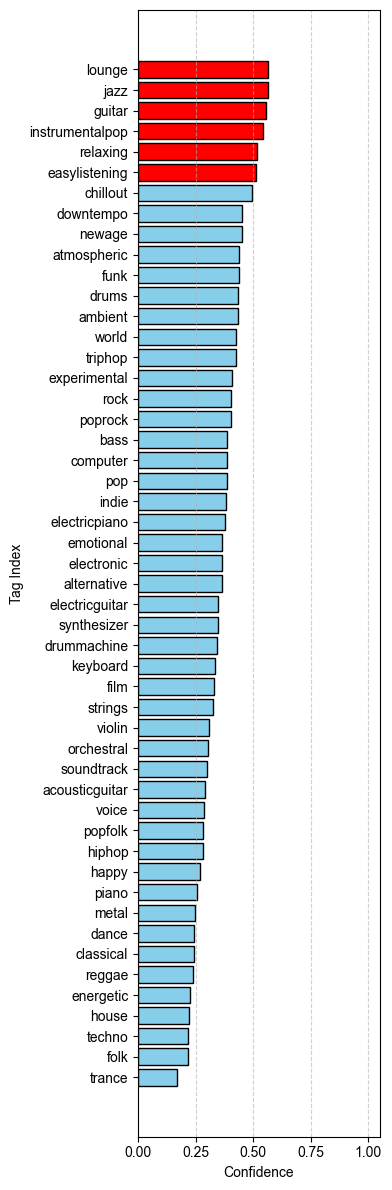

Confidence Scores for Pika Girl


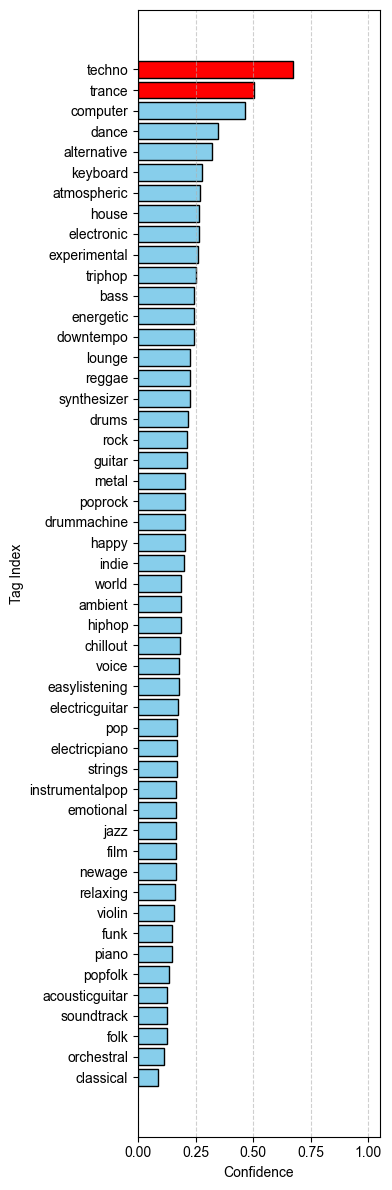

Confidence Scores for 名探偵コナン メイン・テーマ


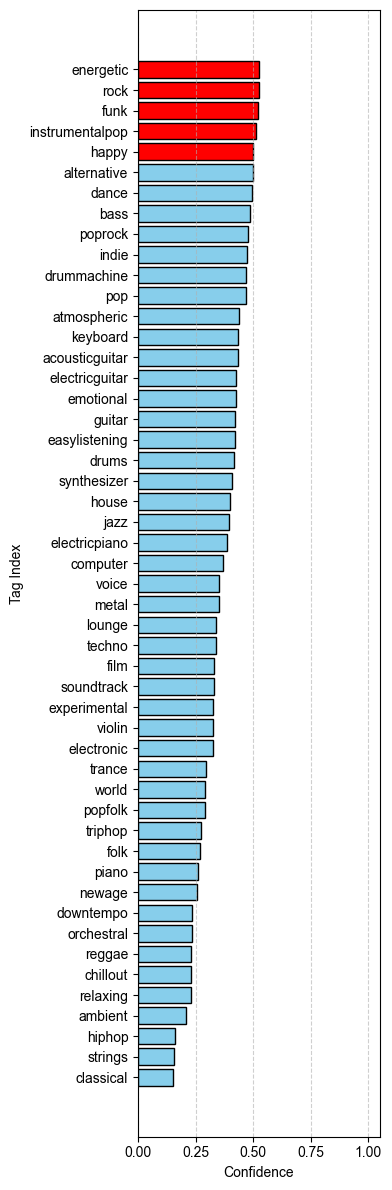

Confidence Scores for Moonlight


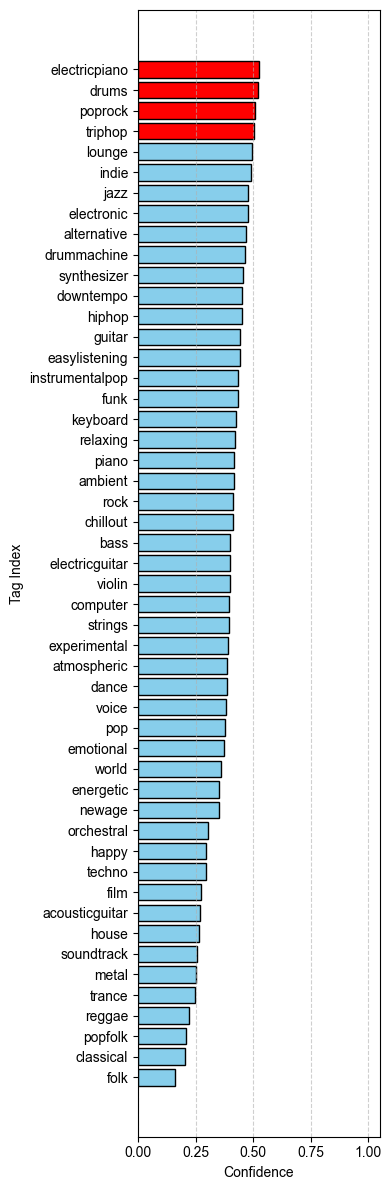

Confidence Scores for at That Place


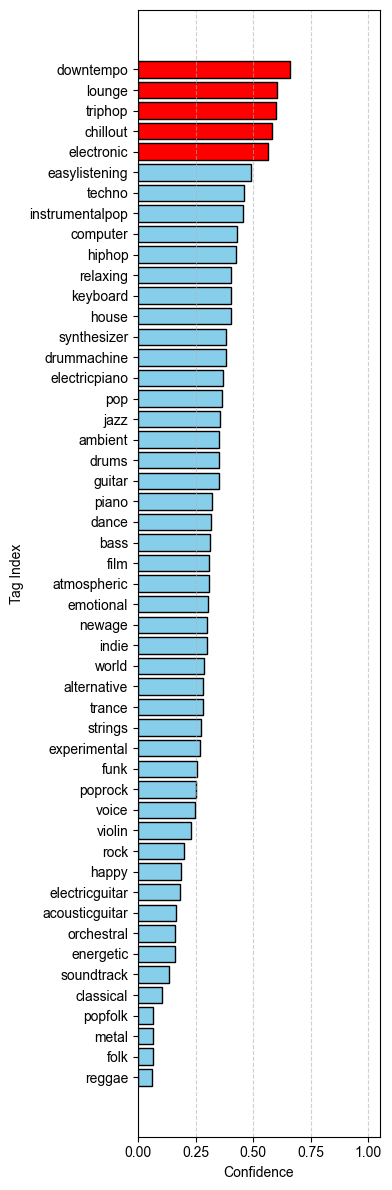

Confidence Scores for Snow-Sleep


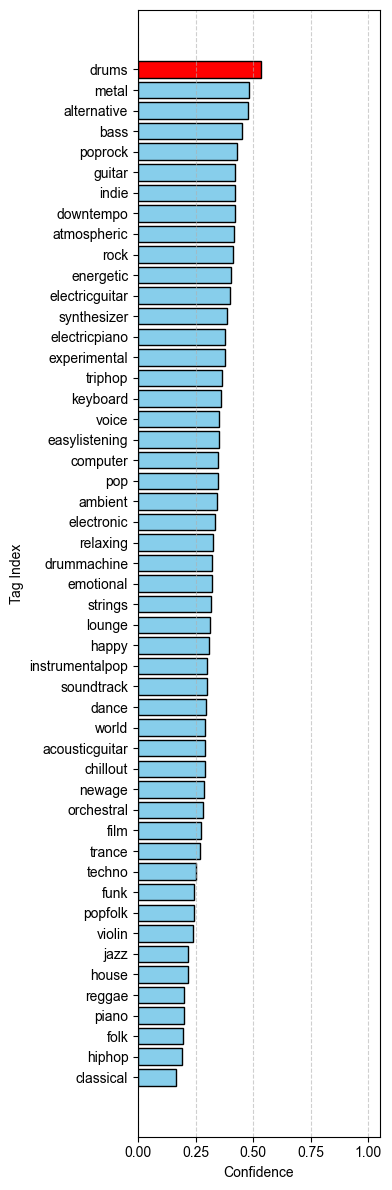

Confidence Scores for The Intrepid


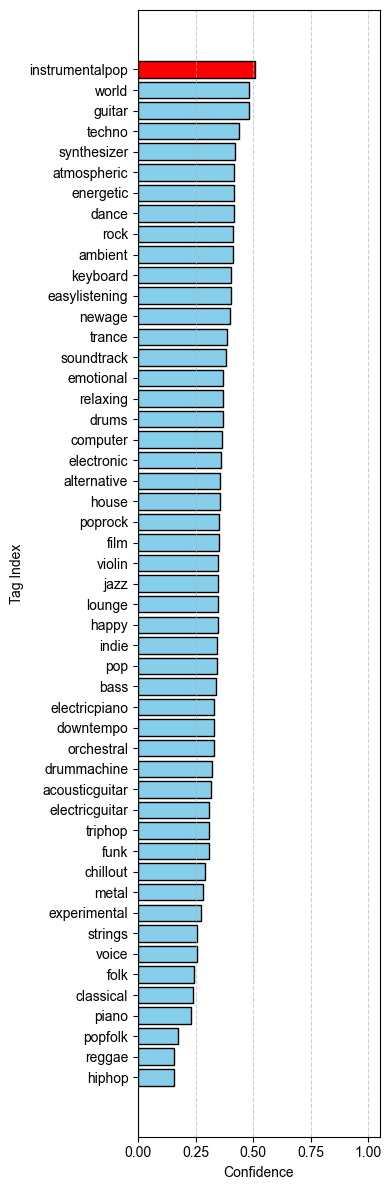

Confidence Scores for Smile Fight


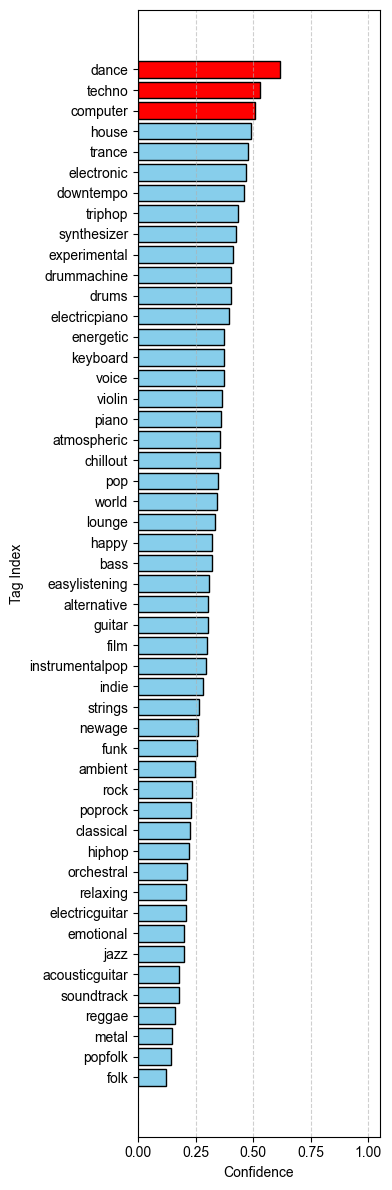

Confidence Scores for I don't care about Christmas though


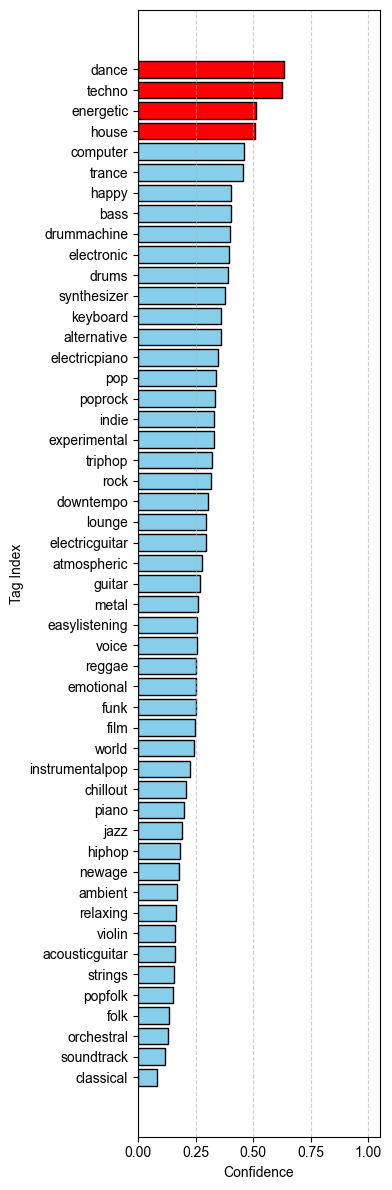

Confidence Scores for Miracle Groovin'


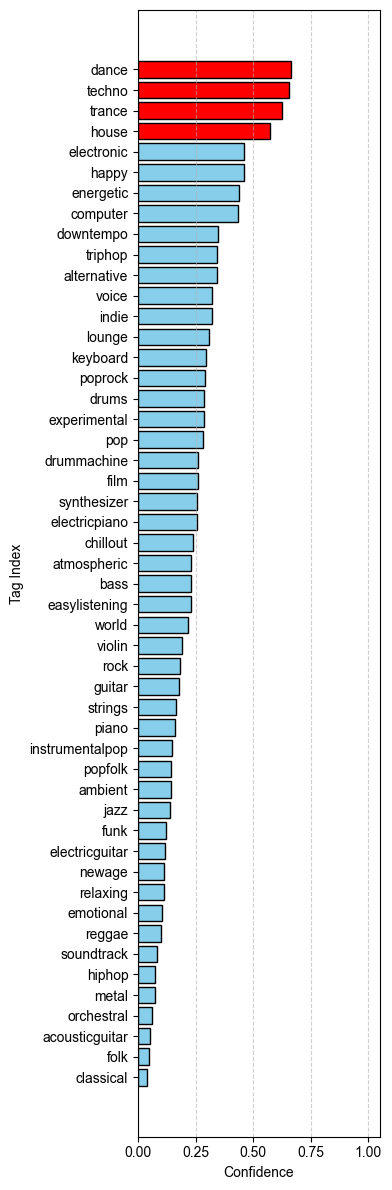

Confidence Scores for Blast Processing


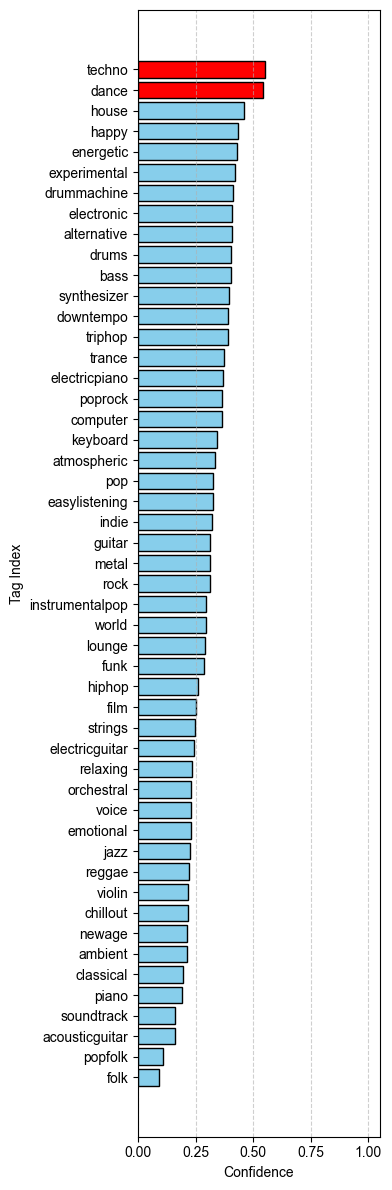

Confidence Scores for 光の方へ


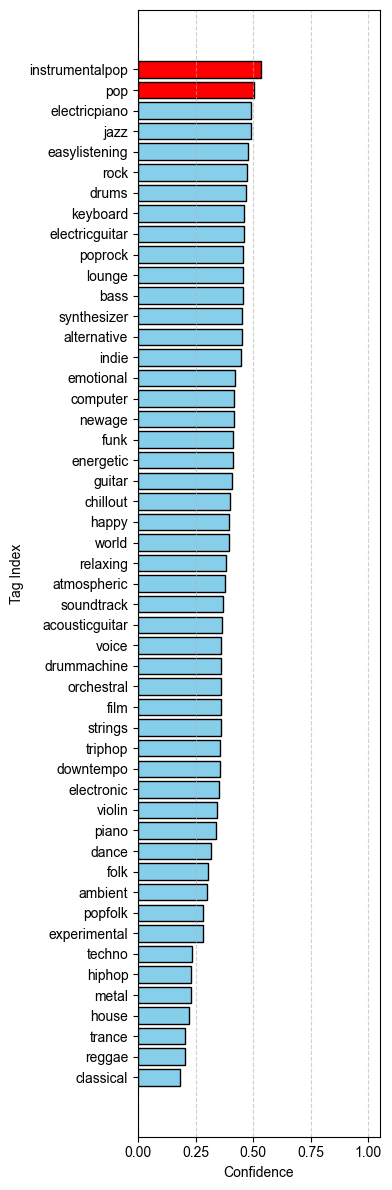

Confidence Scores for Devour Me, Colossus


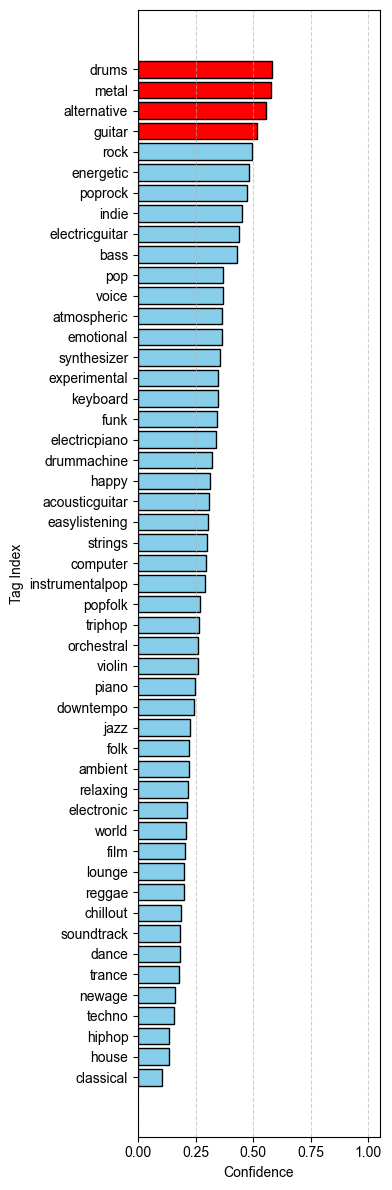

Confidence Scores for Megablast


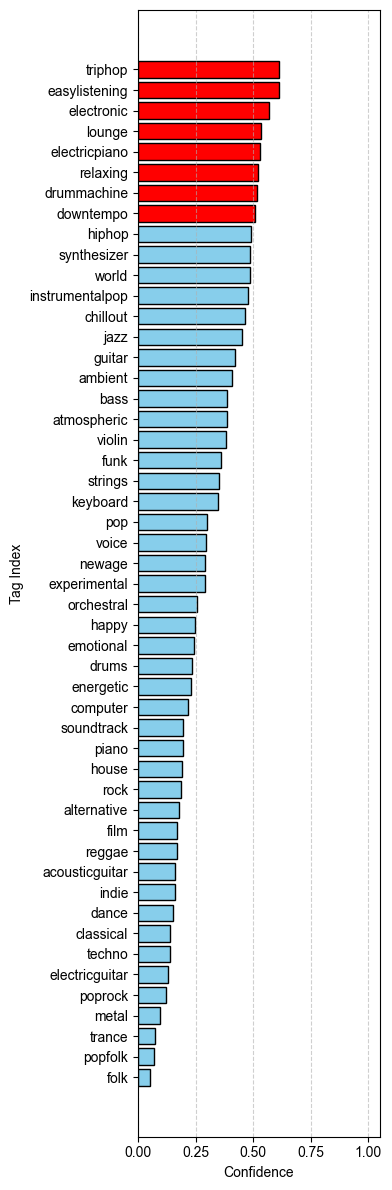

Confidence Scores for w  WWW (feat. Toto Hoshimiya)


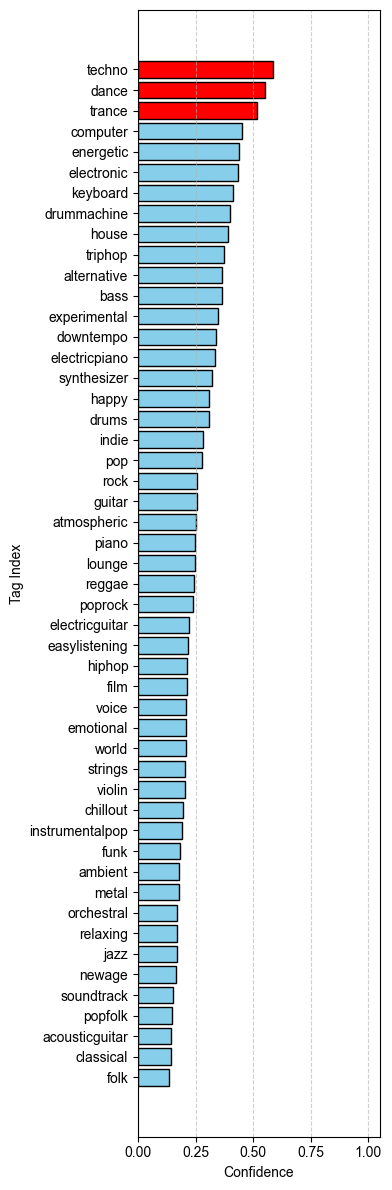

Confidence Scores for 満ちていく体温


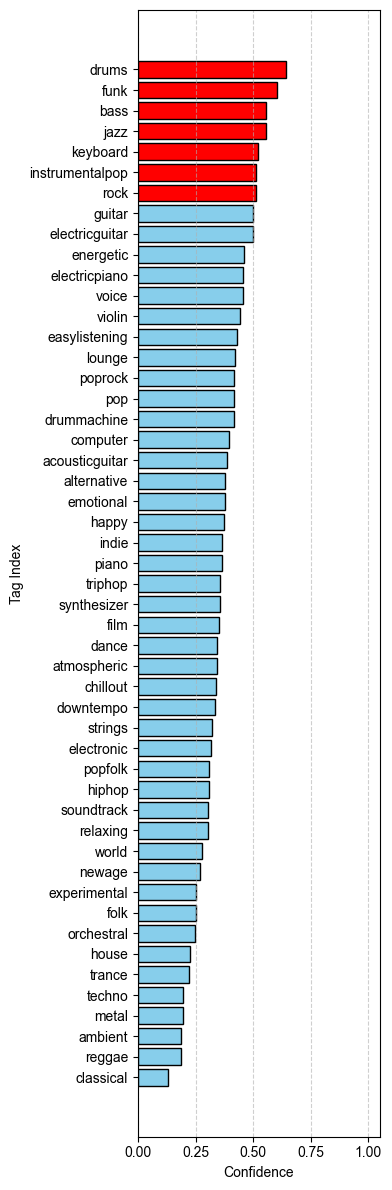

Confidence Scores for 地獄小僧


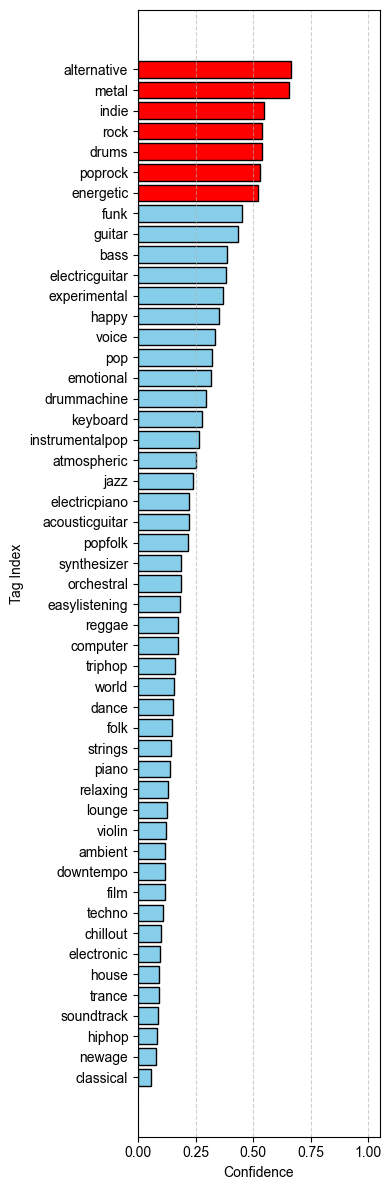

Confidence Scores for Underground


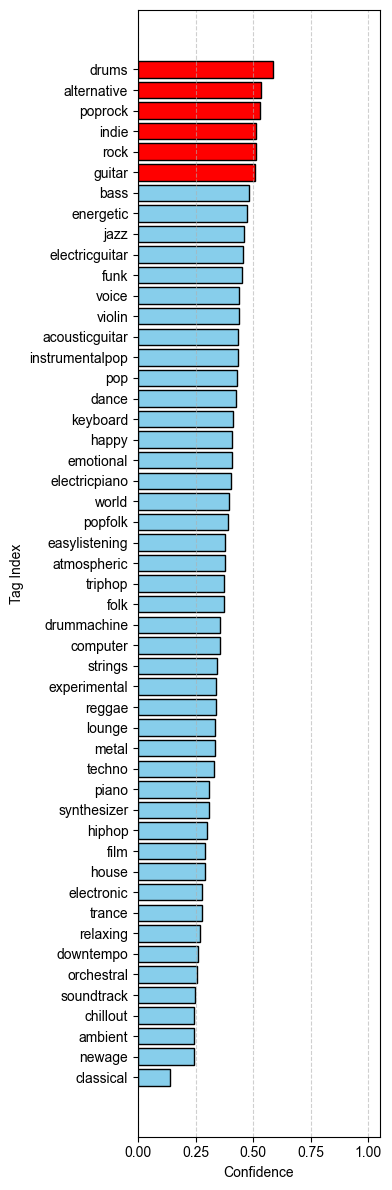

Confidence Scores for Fly Away


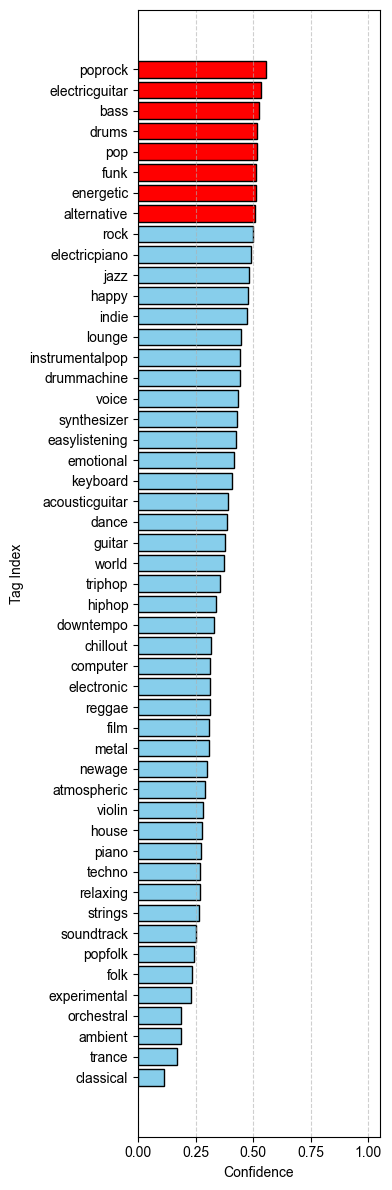

Confidence Scores for Pumped Up Kicks


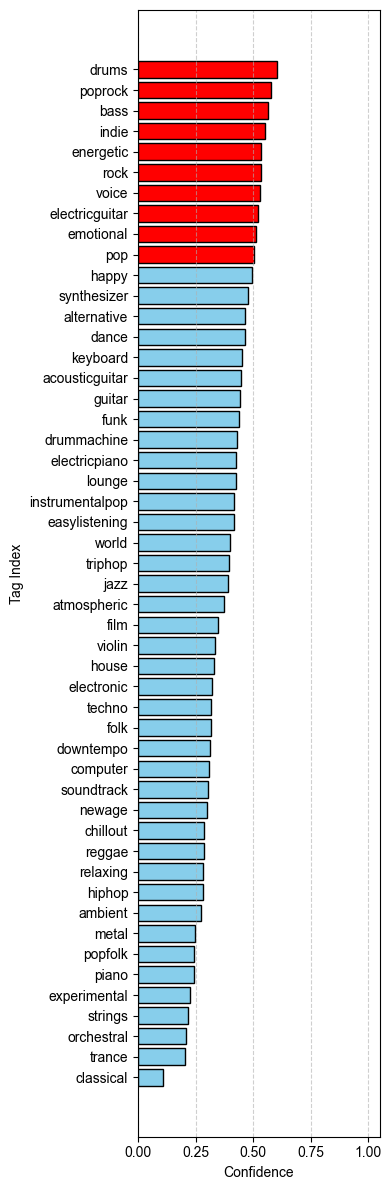

Confidence Scores for Ghetto Child


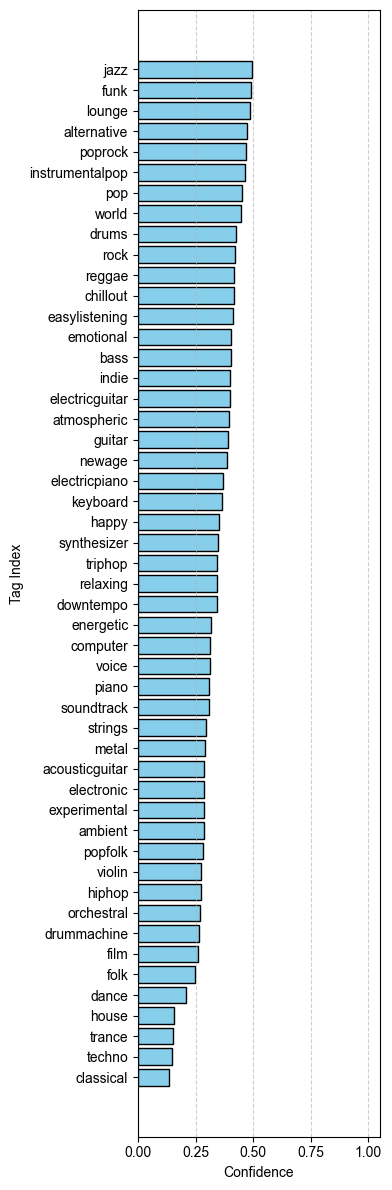

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Specify prediction and actual tag columns
pred_cols = [f'Confidence {reversed_tag_mapping[i]}' for i in range(50)]
actual_cols = [f'Tag {reversed_tag_mapping[i]}' for i in range(50)]

# Plot one graph per row
for idx, row in df.iterrows():
    track_id = row['Track ID']
    confidences = row[pred_cols].values.astype(float)
    actuals = row[actual_cols].values.astype(int)
    tag_names = [reversed_tag_mapping[i] for i in range(50)]

    # Sort by confidence (highest first)
    sort_idx = np.argsort(confidences)
    confidences = confidences[sort_idx]
    actuals = actuals[sort_idx]
    tag_names = [tag_names[i] for i in sort_idx]

    x = np.arange(len(confidences))

    # Plot confidence values as bars
    plt.figure(figsize=(4, 12))

    bar_colors = ['red' if conf > 0.5 else 'skyblue' for conf in confidences]

    bars = plt.barh(x, confidences, color=bar_colors, edgecolor='black')

    # Highlight actual labels where ground truth == 1
    for i, actual in enumerate(actuals):
        if actual == 1:
            bars[i].set_color('purple')
            bars[i].set_edgecolor('white')

    # Optional: Mark actual label positions with a star
    for i, actual in enumerate(actuals):
        if actual == 1:
            plt.plot(i, confidences[i] + 0.1, '*', markersize=10)

    plt.yticks(ticks=x, labels=tag_names)
    # Using this font family as they support kana
    print(f'Confidence Scores for {track_id}')
    plt.rcParams["font.family"] = "Arial"
    plt.ylabel('Tag Index')
    plt.xlabel('Confidence')
    plt.xlim(0, 1.05)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
from torchcam.methods import GradCAM
cam_extractor = GradCAM(model, target_layer="layer4")

In [ ]:
def toMEL(wv, sr):
    spec = librosa.feature.melspectrogram(y=wv, sr=sr)
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    return spec

def process_song(song_path, folder_in, folder_out, transform):
    latents_path_name = os.path.join(folder_out, song_path[:-4] + ".npy")

    if os.path.exists(latents_path_name):
        return

    try:
        wv, sr = librosa.load(os.path.join(folder_in, song_path), sr=44100)
        latent_space = transform(wv, sr)
        np.save(latents_path_name, latent_space)
    except Exception as e:
        print(f"Error processing {song_path}: {e}")

def encodeFolder(folder_in, folder_out, transform, num_threads=8):
    os.makedirs(folder_out, exist_ok=True)
    song_paths = os.listdir(folder_in)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(process_song, song_path, folder_in, folder_out, transform)
            for song_path in song_paths
        ]
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {folder_in}"):
            pass

# Run for folders 50 to 98
for index in range(0, 99):
    folder_name = f"E:/mtg-jamendo/{index:02}"
    encodeFolder(folder_name, "E:/SongsDataset/MELSPEC/", toMEL)